In [1]:
import torch
import torch.nn as nn

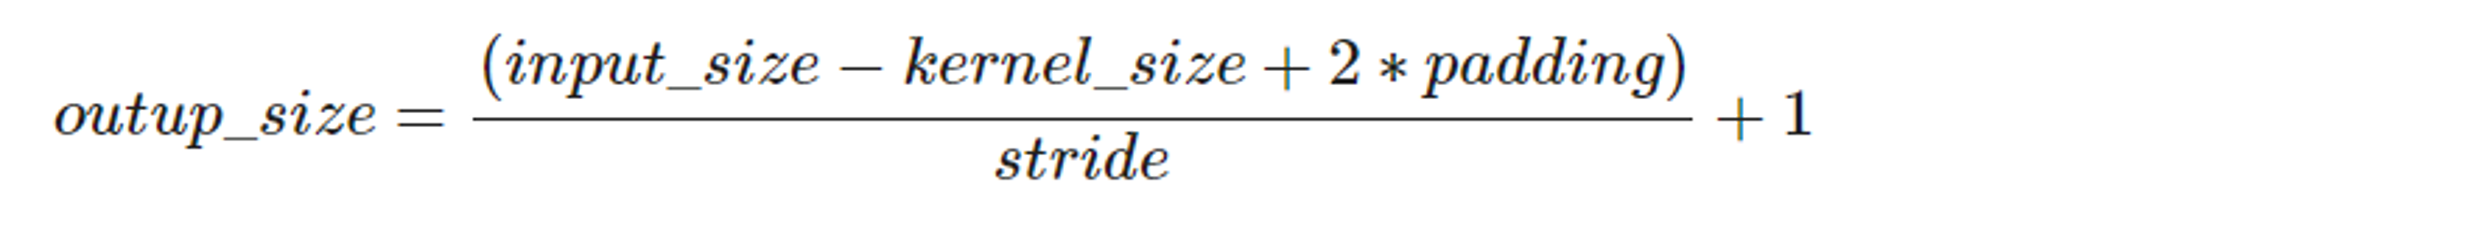

In [2]:
# 배치 크기 × 채널 × 높이(height) × 너비(widht)의 크기의 텐서를 선언
inputs = torch.Tensor(1, 1, 28, 28)
print(f'텐서의 크기 : {inputs.shape}')

텐서의 크기 : torch.Size([1, 1, 28, 28])


- stride는 default로 stride=(1, 1)

In [3]:
# 첫번째 Conv2D
conv1 = nn.Conv2d(1, 32, 3, padding=1)
print(conv1)

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [4]:
# 두번째 Conv2D
conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
print(conv2)

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [5]:
# 맥스 풀링
pool = nn.MaxPool2d(2) # 2 -> Kernel_size, stride는 default로 kernel_size와 동일, padding은 0
print(pool)

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [ ]:
# 연결하여 모델 만들기
# 28 - 3 + 2*1 + 1 -> 28
out = conv1(inputs)
print(out.shape)

torch.Size([1, 32, 28, 28])


In [ ]:
# (28 - 2)/2 + 1 = 14
out = pool(out)
print(out.shape)

torch.Size([1, 32, 14, 14])


In [ ]:
# 두번째 Conv2D 통과
# (14 - 3 + 2)*1 + 1 = 14
out = conv2(out)
print(out.shape)


torch.Size([1, 64, 14, 14])


In [ ]:
# (14 - 2)/2 + 1 = 7
out = pool(out)
print(out.shape)

torch.Size([1, 64, 7, 7])


ceil_mode

- 입력 크기 7x7, kernel_size=2, stride=2라면:

- ceil_mode=False → 출력: 3x3 (7/2 = 3.5 → floor → 3)

- ceil_mode=True → 출력: 4x4 (7/2 = 3.5 → ceil → 4)

In [ ]:
out.size(0), out.size(1), out.size(2), out.size(3)

(1, 64, 7, 7)

In [ ]:
# 첫번째 차원인 배치 차원은 그대로 두고 나머지는 펼쳐라
# [1, 64*7*7]
out = out.view(out.size(0), -1)
print(out.shape)

torch.Size([1, 3136])


In [ ]:
fc = nn.Linear(3136, 10) # input_dim = 3,136, output_dim = 10
out = fc(out)
print(out.shape)

torch.Size([1, 10])


CNN으로 MNIST 분류하기

In [11]:
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.init

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [9]:
learning_rate = 0.001
training_epochs = 15
batch_size = 16

In [13]:
mnist_train = datasets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # 텐서로 변환
                          download=True)

mnist_test = datasets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # 텐서로 변환
                         download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.6MB/s]


In [14]:
train_loader = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

valid_loader = DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)


In [15]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 첫번째층
        # ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 두번째층
        # ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 전결합층 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.fc(out)
        return out

In [16]:
# CNN 모델 정의
model = CNN().to(device)

In [17]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
total_train_batch = len(train_loader)
total_test_batch = len(valid_loader)
print(f'총 배치의 수 : {total_train_batch}, {total_test_batch}')

총 배치의 수 : 3750, 625


In [ ]:
len(train_loader), len(train_loader.dataset)

(6000, 60000)

In [19]:
from tqdm import tqdm

train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

num_epochs = 10
for epoch in range(num_epochs):  # Loop for num epochs
    model.train()  # Set the model to training mode
    total_train_loss, total_valid_loss = 0.0, 0.0
    total_train_correct, total_valid_correct = 0.0, 0.0

    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}", unit=" batch")):  # Iterate over batches of data
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()  # Clear gradients from the previous iteration
        output = model(data)  # Forward pass through the model
        loss = criterion(output, target)  # Calculate the loss
        loss.backward()  # Compute gradients (backpropagation)
        optimizer.step()  # Update model parameters

        total_train_loss += loss.item() * data.size(0)  # Accumulate test loss

        pred = output.argmax(dim=1, keepdim=True)  # Get predicted class
        total_train_correct += pred.eq(target.view_as(pred)).sum().item()  # Update correct predictions
        # print('train_correct', train_correct)

    model.eval()  # Set the model to evaluation mode
    total_valid_loss = 0
    total_valid_correct = 0
    with torch.no_grad():  # Disable gradient calculations for efficiency
        for data, target in valid_loader:  # Iterate over test data
            data, target = data.to(device), target.to(device)
            output = model(data)

            total_valid_loss += criterion(output, target).item() * data.size(0) # Accumulate test loss
            pred = output.argmax(dim=1, keepdim=True)  # Get predicted class
            total_valid_correct += pred.eq(target.view_as(pred)).sum().item()  # Update correct predictions

    # calculate average loss over an epoch
    train_loss = total_train_loss/len(train_loader.dataset)
    valid_loss = total_valid_loss/len(valid_loader.dataset)
    train_correct = total_train_correct/len(train_loader.dataset)
    valid_correct = total_valid_correct/len(valid_loader.dataset)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_correct)
    valid_accs.append(valid_correct)

    # tqdm 상태창에 추가 정보 표시
#     tqdm.write(f"[{epoch}/{num_epochs}] Batch {batch_idx} Training Loss: {train_loss:.3f} Valid Loss: {valid_loss:.3f}  Training Accuracy: {100. * train_correct:.3f}% \
#  Valid Accuracy: {100. * valid_correct:.3f}% \n")

    print(f'Epoch: {epoch}  Training Loss: {train_loss:.3f} \
            Training Accuracy: {100. * train_correct:.3f}%  \
             Valid Loss: {valid_loss:.6f}  Valid Accuracy: {100. * valid_correct:.3f}%')


Epoch 0: 100%|██████████| 3750/3750 [00:16<00:00, 227.89 batch/s]


Epoch: 0  Training Loss: 0.126             Training Accuracy: 96.092%               Valid Loss: 0.046667  Valid Accuracy: 98.490%


Epoch 1: 100%|██████████| 3750/3750 [00:14<00:00, 258.83 batch/s]


Epoch: 1  Training Loss: 0.045             Training Accuracy: 98.598%               Valid Loss: 0.035170  Valid Accuracy: 98.790%


Epoch 2: 100%|██████████| 3750/3750 [00:14<00:00, 260.34 batch/s]


Epoch: 2  Training Loss: 0.033             Training Accuracy: 98.922%               Valid Loss: 0.033145  Valid Accuracy: 98.840%


Epoch 3: 100%|██████████| 3750/3750 [00:14<00:00, 252.36 batch/s]


Epoch: 3  Training Loss: 0.024             Training Accuracy: 99.230%               Valid Loss: 0.033464  Valid Accuracy: 98.850%


Epoch 4: 100%|██████████| 3750/3750 [00:14<00:00, 260.91 batch/s]


Epoch: 4  Training Loss: 0.018             Training Accuracy: 99.428%               Valid Loss: 0.029756  Valid Accuracy: 99.020%


Epoch 5: 100%|██████████| 3750/3750 [00:14<00:00, 258.50 batch/s]


Epoch: 5  Training Loss: 0.014             Training Accuracy: 99.587%               Valid Loss: 0.037843  Valid Accuracy: 98.810%


Epoch 6: 100%|██████████| 3750/3750 [00:14<00:00, 254.20 batch/s]


Epoch: 6  Training Loss: 0.011             Training Accuracy: 99.632%               Valid Loss: 0.034580  Valid Accuracy: 99.080%


Epoch 7: 100%|██████████| 3750/3750 [00:14<00:00, 262.78 batch/s]


Epoch: 7  Training Loss: 0.010             Training Accuracy: 99.657%               Valid Loss: 0.038344  Valid Accuracy: 98.920%


Epoch 8: 100%|██████████| 3750/3750 [00:14<00:00, 260.06 batch/s]


Epoch: 8  Training Loss: 0.008             Training Accuracy: 99.757%               Valid Loss: 0.036653  Valid Accuracy: 99.030%


Epoch 9: 100%|██████████| 3750/3750 [00:14<00:00, 253.93 batch/s]


Epoch: 9  Training Loss: 0.008             Training Accuracy: 99.732%               Valid Loss: 0.037950  Valid Accuracy: 99.130%


In [ ]:
train_losses

[0.11528463509061233,
 0.04372670180717281,
 0.03056907778675321,
 0.02306502896132319,
 0.017527709531443832,
 0.014129334224187601,
 0.011429801792606354,
 0.009327251552569086,
 0.00805066347954928,
 0.0072853475135329915]

In [ ]:
valid_losses

[0.04859343039018859,
 0.03343899858261909,
 0.02600381782552995,
 0.026266007762165346,
 0.03232843687633144,
 0.027044677751293243,
 0.03403401670857899,
 0.03827963621091365,
 0.03864655192149169,
 0.03934948537573797]

In [ ]:
train_losses, valid_losses = [], []
train_accs,   valid_accs  = [], []

for epoch in range(30):
    # ── 학습
    model.train()
    total_train_loss = 0.0
    total_train_correct = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss   = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_train_loss   += loss.item() * data.size(0)
        total_train_correct += output.argmax(1).eq(target).sum().item()

    # ── 평가
    model.eval()
    total_valid_loss = 0.0
    total_valid_correct = 0

    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_valid_loss    += criterion(output, target).item() * data.size(0)
            total_valid_correct += output.argmax(1).eq(target).sum().item()

    # ── 평균 계산
    train_loss = total_train_loss / len(train_loader.dataset)
    valid_loss = total_valid_loss / len(valid_loader.dataset)

    train_acc = total_train_correct / len(train_loader.dataset)
    valid_acc = total_valid_correct / len(valid_loader.dataset)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    print(
        f'Epoch: {epoch}  '
        f'Train Loss: {train_loss:.3f}  '
        f'Valid Loss: {valid_loss:.3f}  '
        f'Train Acc: {train_acc*100:.3f}%  '
        f'Valid Acc: {valid_acc*100:.3f}%'
    )


Epoch: 0  Train Loss: 0.117  Valid Loss: 0.043  Train Acc: 96.432%  Valid Acc: 98.590%
Epoch: 1  Train Loss: 0.043  Valid Loss: 0.036  Train Acc: 98.643%  Valid Acc: 98.800%
Epoch: 2  Train Loss: 0.032  Valid Loss: 0.037  Train Acc: 98.972%  Valid Acc: 98.800%
Epoch: 3  Train Loss: 0.023  Valid Loss: 0.039  Train Acc: 99.307%  Valid Acc: 98.750%
Epoch: 4  Train Loss: 0.018  Valid Loss: 0.042  Train Acc: 99.432%  Valid Acc: 98.690%
Epoch: 5  Train Loss: 0.014  Valid Loss: 0.036  Train Acc: 99.533%  Valid Acc: 98.910%
Epoch: 6  Train Loss: 0.012  Valid Loss: 0.036  Train Acc: 99.627%  Valid Acc: 99.080%
Epoch: 7  Train Loss: 0.011  Valid Loss: 0.035  Train Acc: 99.652%  Valid Acc: 99.050%
Epoch: 8  Train Loss: 0.008  Valid Loss: 0.036  Train Acc: 99.740%  Valid Acc: 99.140%
Epoch: 9  Train Loss: 0.008  Valid Loss: 0.042  Train Acc: 99.730%  Valid Acc: 99.100%
Epoch: 10  Train Loss: 0.006  Valid Loss: 0.045  Train Acc: 99.785%  Valid Acc: 99.090%
Epoch: 11  Train Loss: 0.006  Valid Loss: 

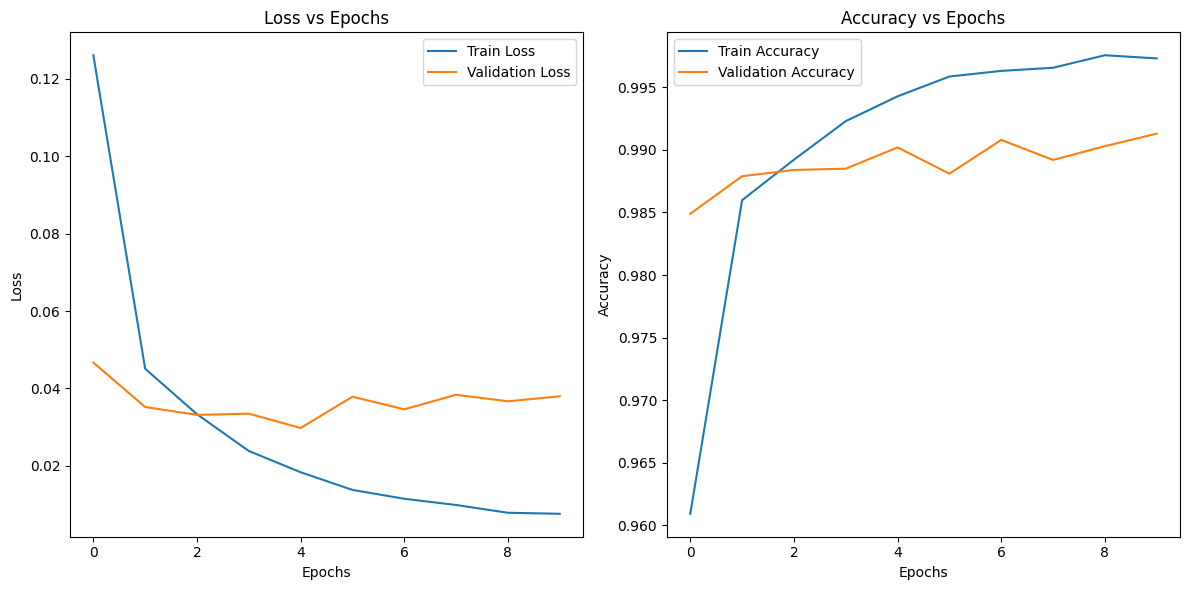

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(valid_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# # 학습을 진행하지 않을 것이므로 torch.no_grad() 사용
# with torch.no_grad():
#     # 테스트 데이터를 모델에 입력하기 위한 준비
#     X_test = mnist_test.data.view(len(mnist_test), 1, 28, 28).float().to(device)  # 테스트 데이터셋의 크기를 맞추고, 연산을 위한 장치로 이동
#     Y_test = mnist_test.targets.to(device)  # 테스트 데이터셋의 레이블을 연산을 위한 장치로 이동

#     print(X_test.shape)

#     # 모델 예측 수행
#     prediction = model(X_test)  # 테스트 데이터에 대해 모델이 예측한 결과값

#     # 예측 결과와 실제 레이블 비교
#     correct_prediction = torch.argmax(prediction, 1) == Y_test  # 예측된 클래스와 실제 레이블이 일치하는지 확인

#     # 정확도 계산
#     accuracy = correct_prediction.float().mean()  # 정확도를 계산하기 위해 일치하는 예측의 평균을 구함
#     print('Accuracy:', accuracy.item())  # 정확도를 출력


torch.Size([10000, 1, 28, 28])
Accuracy: 0.9858999848365784
